# Imports

In [1]:
from cartopy import crs
import collections
import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper
import csv
from datetime import datetime
import db_connection as db_con
from descartes import PolygonPatch
import descartes
import folium
from functools import partial
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
import io
from io import StringIO
from matplotlib import cm
from matplotlib.patches import Ellipse, Polygon
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import psycopg2
import psycopg2.extras as extras
import scipy.stats
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from sqlalchemy import create_engine, func, distinct
import sys

## Matplotlib settings

In [2]:
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text

colors =  ["#3388ff","#A1E2E6", "#E6BDA1", "#B3A16B", "#678072", "#524A4A"]

# Simple DB Connection

In [3]:
def read_sql_inmem_uncompressed(query, db_engine):
    copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(query=query, head="HEADER")
    conn = db_engine.raw_connection()
    cur = conn.cursor()
    store = io.StringIO()
    cur.copy_expert(copy_sql, store)
    store.seek(0)
    df = pd.read_csv(store)
    cur.close()
    return df


In [4]:
# Import credential and connection settings
db_name = db_con.db_name
db_username = db_con.db_username
db_host = db_con.db_host
db_port = db_con.db_port
db_pwd = db_con.db_pwd
engine_string = f"postgresql://{db_username}:{db_pwd}@{db_host}:{db_port}/{db_name}"
db_engine = create_engine(engine_string)

# General Nordic map

In [5]:
# Load NUTS2 geodata
nordics_and_balt = gpd.read_file('countries/NordicBalticsIceland.gpkg')
# Split into countries
nordics = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('DK|FI|NO|SE|IS')]
denmark_bounds = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('DK')]
norway_bounds = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('NO')]
finland_bounds = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('FI')]
sweden_bounds = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('SE')]
iceland_bounds = nordics_and_balt[nordics_and_balt['CNTR_ID'].str.match('IS')]

/home/havard/anaconda3/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [6]:
# Cities to plot
cities_list = ['Copenhagen, Denmark','Malmö, Sweden','Oslo, Norway','Helsinki, Finland','Stockholm, Sweden','Tornio, Finland','Haparanda, Sweden','Göteborg, Sweden', 'Tromsø, Norway','Bergen, Norway', 'Århus, Denmark','Stavanger,Norway','Reykjavik, Iceland', 'Trondheim, Norway', ' Vasa, Bangatan, Finland','Umeå, Sweden','Oulu, Finland','Sundsvall, Sweden','Turku, Finland', 'Kiruna, Sweden','Ålborg, Denmark','Luleå, Sweden', 'Rovaniemi, Finland', 'Strömstad, Sweden', 'Halden, Norway']
cities = pd.DataFrame(cities_list)
# Set Nominatim credentials
geolocator = Nominatim(user_agent="haavard")
# Geocoder instance
geocode2 = partial(geolocator.geocode, language="en")
# Geocode cities
cities_df = geocode(cities[0], provider='nominatim', user_agent='haavard', timeout=4)
cities_df = cities_df.to_crs(epsg=3035)
# Get coordinates to columns
cities_df['x'] = cities_df['geometry'].apply(lambda point: point.x)
cities_df['y'] = cities_df['geometry'].apply(lambda point: point.y)
# Correct labels
cities_df['label'] = cities_df['address'].apply(lambda x: geocode2(x))
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(","))[0])
cities_df['label'] = cities_df['label'].apply(lambda x: list(str(x).split(" "))[0])
del cities

## Plot

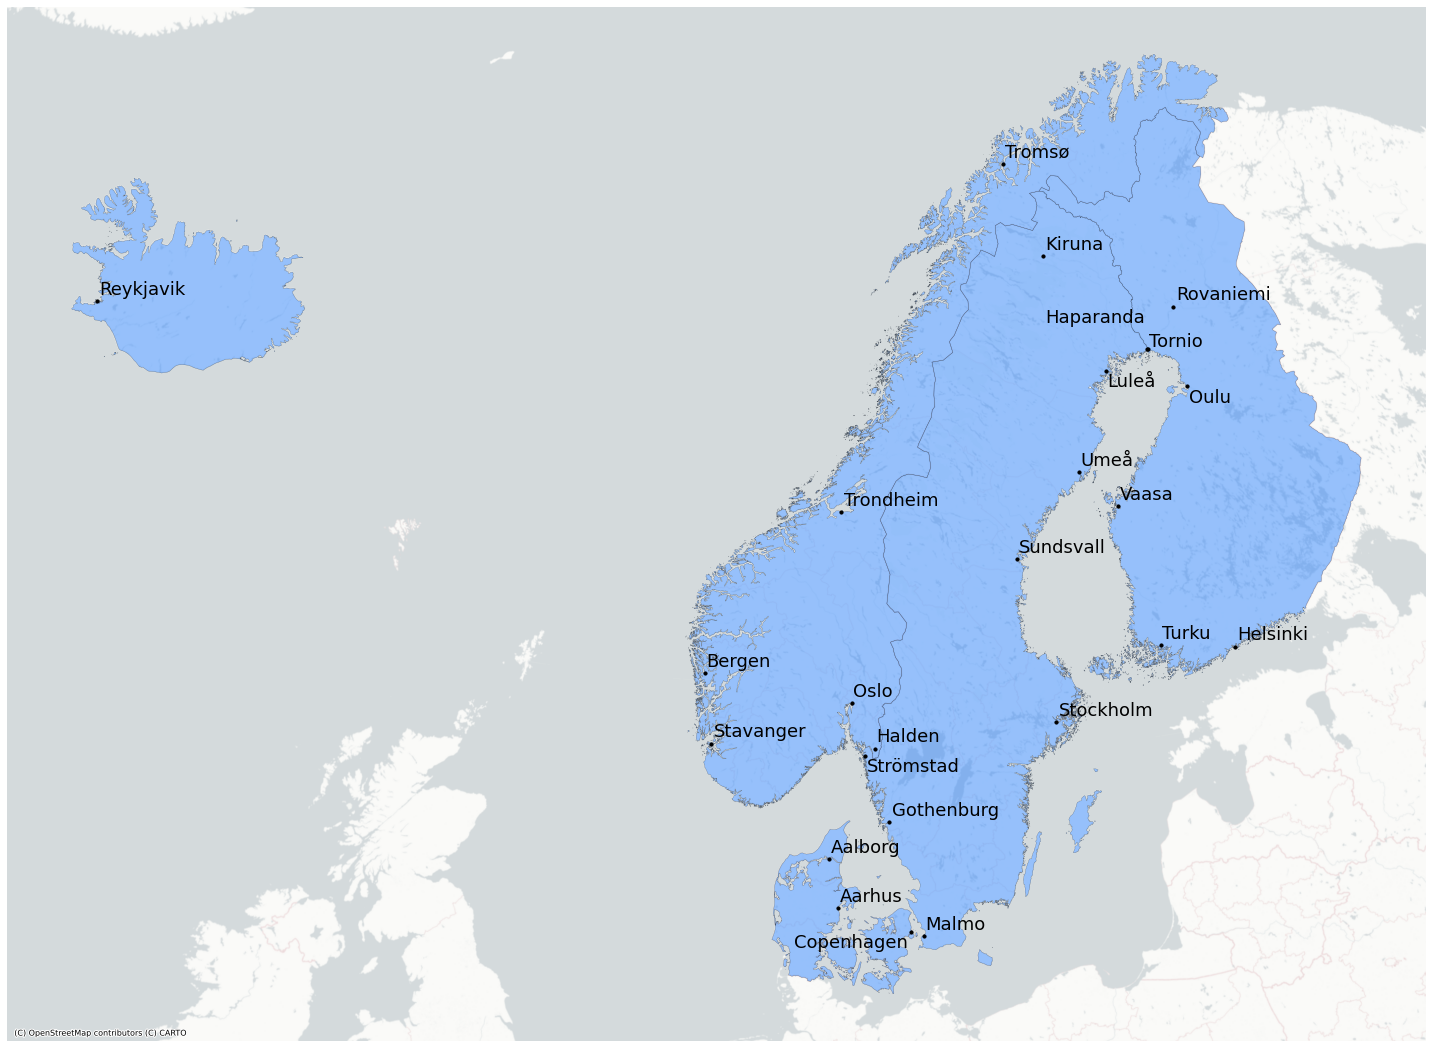

In [7]:
fig, ax = plt.subplots(figsize=(20, 18))

nordics.plot(ax=ax, color=colors[0], edgecolor='black', linewidth=0.3, alpha=0.5) # 2 - Projected plot

ctx.add_basemap(ax,crs=nordics.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels) # 3
cities = gpd.sjoin(cities_df,nordics, how='inner', op='within')
cit = cities.plot(ax=ax,color='black',markersize=10, zorder=6)
texts = [cit.text(cities['x'].iloc[i], cities['y'].iloc[i], cities['label'].iloc[i], ha='center', va='center',fontsize=18,zorder=7) for i in range(len(cities))]
adjust_text(texts)
ax.axis("off")
plt.tight_layout()
#plt.savefig('../imgs/nordicMap.png', dpi=150)
plt.show()

# General statistics

## Pre-COVID-19 points

In [8]:
# SQL-query
query = 'SELECT id,created_at, user_id,place_type, country_code, lon,lat, spatial_level, post_region FROM pre_covid'
# Read data to dataframe
pre_points = db_con.read_sql_inmem_uncompressed(query, db_engine)

In [9]:
print(f"Number of users: {pre_points['user_id'].nunique()}")
print(f"Number of tweets: {pre_points['id'].nunique()}")
print(pre_points['country_code'].value_counts())
print(pre_points['spatial_level'].value_counts())

Number of users: 145254
Number of tweets: 5231716
SE    2279442
FI    1280623
NO     761280
DK     738650
IS     171721
Name: country_code, dtype: int64
centroid    4798731
city         404874
country       28000
poi              64
admin            47
Name: spatial_level, dtype: int64


## COVID-19 points

In [10]:
# SQL-query
query = 'SELECT id,created_at, user_id,place_type, country_code, lon,lat, spatial_level, post_region FROM post_covid'
# Read data to dataframe
post_points = db_con.read_sql_inmem_uncompressed(query, db_engine)

In [11]:
print(f"Number of users: {post_points['user_id'].nunique()}")
print(f"Number of tweets: {post_points['id'].nunique()}")
print(post_points['country_code'].value_counts())
print(post_points['spatial_level'].value_counts())

Number of users: 87438
Number of tweets: 5455980
SE    2204988
FI    1454906
NO     781906
DK     770963
IS     243217
Name: country_code, dtype: int64
centroid    5161313
city         284563
country       10094
poi               7
admin             3
Name: spatial_level, dtype: int64


### Unique users in both points data

In [12]:
pre_user_list = list(pre_points['user_id'].unique())
post_user_list = list(post_points['user_id'].unique())
unique_combined = pre_user_list + list(set(post_user_list) - set(pre_user_list))
print(f"Number of unique users over both point datasets: {len(unique_combined)}")

Number of unique users over both point datasets: 187430


## Pre-COVID-19 lines

In [13]:
print('--- Pre-COVID-19 lines ---')
# SQL-query
query = 'SELECT geometry,user_id,dest_country,orig_time,dest_time,duration,post_region,dest_region,region_move,cb_move,distance_km,row_id,country_code FROM pre_covid_lines'
# Read data to dataframe
pre_lines = db_con.read_sql_inmem_uncompressed(query, db_engine)
# Apply wkt
pre_lines['geometry'] = pre_lines['geometry'].apply(wkt.loads)
# Convert to GeoDataFrame
pre_lines_gdf = gpd.GeoDataFrame(pre_lines, geometry='geometry')
# CRS
pre_lines_gdf.crs = "EPSG:4326"
# Delete dataframe
del pre_lines
# Convert timestamps
pre_lines_gdf['orig_time'] = pre_lines_gdf['orig_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
pre_lines_gdf['dest_time'] = pre_lines_gdf['dest_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
# Add month
pre_lines_gdf['month'] = pre_lines_gdf['dest_time'].apply(lambda x: x.month)
pre_lines_gdf['yearmonth'] = pre_lines_gdf['dest_time'].apply(lambda x: int(str(x.year)+str(x.month).zfill(2)))
# Add day of week
pre_lines_gdf['orig_day_of_week'] = pre_lines_gdf['orig_time'].apply(lambda x: x.dayofweek)
pre_lines_gdf['dest_day_of_week'] = pre_lines_gdf['dest_time'].apply(lambda x: x.dayofweek)

print(f"Number of movements: {len(pre_lines_gdf)}")
print(f"Number of users: {pre_lines_gdf['user_id'].nunique()}")
print(f"Median number of travels: {pre_lines_gdf['user_id'].value_counts().median()}")

--- Pre-COVID-19 lines ---
Number of movements: 44126
Number of users: 17549
Median number of travels: 2.0


In [14]:
pre_dk_fi = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('DK-FI|FI-DK')]
pre_dk_ic = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('DK-IS|IS-DK')]
pre_dk_no = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('DK-NO|NO-DK')]
pre_dk_sw = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('DK-SE|SE-DK')]
pre_fi_ic = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('FI-IS|IS-FI')]
pre_fi_no = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('FI-NO|NO-FI')]
pre_fi_sw = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('FI-SE|SE-FI')]
pre_ic_no = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('IS-NO|NO-IS')]
pre_ic_sw = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('IS-SE|SE-IS')]
pre_no_sw = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('NO-SE|SE-NO')]
print(f"Lines between DK-FI: {len(pre_dk_fi)}")
print(f"Lines between DK-IS: {len(pre_dk_ic)}")
print(f"Lines between DK-NO: {len(pre_dk_no)}")
print(f"Lines between DK-SE: {len(pre_dk_sw)}")
print(f"Lines between FI-IS: {len(pre_fi_ic)}")
print(f"Lines between FI-NO: {len(pre_fi_no)}")
print(f"Lines between FI-SE: {len(pre_fi_sw)}")
print(f"Lines between IS-NO: {len(pre_ic_no)}")
print(f"Lines between IS-SE: {len(pre_ic_sw)}")
print(f"Lines between NO-SE: {len(pre_no_sw)}")

Lines between DK-FI: 2543
Lines between DK-IS: 953
Lines between DK-NO: 4345
Lines between DK-SE: 13994
Lines between FI-IS: 658
Lines between FI-NO: 2680
Lines between FI-SE: 8252
Lines between IS-NO: 1341
Lines between IS-SE: 889
Lines between NO-SE: 8471


### Distances

In [15]:
print('--- Pre-COVID-19 lines median distance ---')
print(f"Median distance for total: {round(pre_lines_gdf['distance_km'].median(),2)}")
print('--- Distance median for countries ---')
print(f"Median distance between DK-FI: {round(pre_dk_fi['distance_km'].median(),2)}")
print(f"Median distance between DK-IS: {round(pre_dk_ic['distance_km'].median(),2)}")
print(f"Median distance between DK-NO: {round(pre_dk_no['distance_km'].median(),2)}")
print(f"Median distance between DK-SE: {round(pre_dk_sw['distance_km'].median(),2)}")
print(f"Median distance between FI-IS: {round(pre_fi_ic['distance_km'].median(),2)}")
print(f"Median distance between FI-NO: {round(pre_fi_no['distance_km'].median(),2)}")
print(f"Median distance between FI-SE: {round(pre_fi_sw['distance_km'].median(),2)}")
print(f"Median distance between IS-NO: {round(pre_ic_no['distance_km'].median(),2)}")
print(f"Median distance between IS-SE: {round(pre_ic_sw['distance_km'].median(),2)}")
print(f"Median distance between NO-SE: {round(pre_no_sw['distance_km'].median(),2)}")

--- Pre-COVID-19 lines median distance ---
Median distance for total: 435.2
--- Distance median for countries ---
Median distance between DK-FI: 890.6
Median distance between DK-IS: 1988.4
Median distance between DK-NO: 496.27
Median distance between DK-SE: 142.44
Median distance between FI-IS: 2256.92
Median distance between FI-NO: 792.02
Median distance between FI-SE: 404.66
Median distance between IS-NO: 1564.15
Median distance between IS-SE: 1987.2
Median distance between NO-SE: 407.6


### Line chart

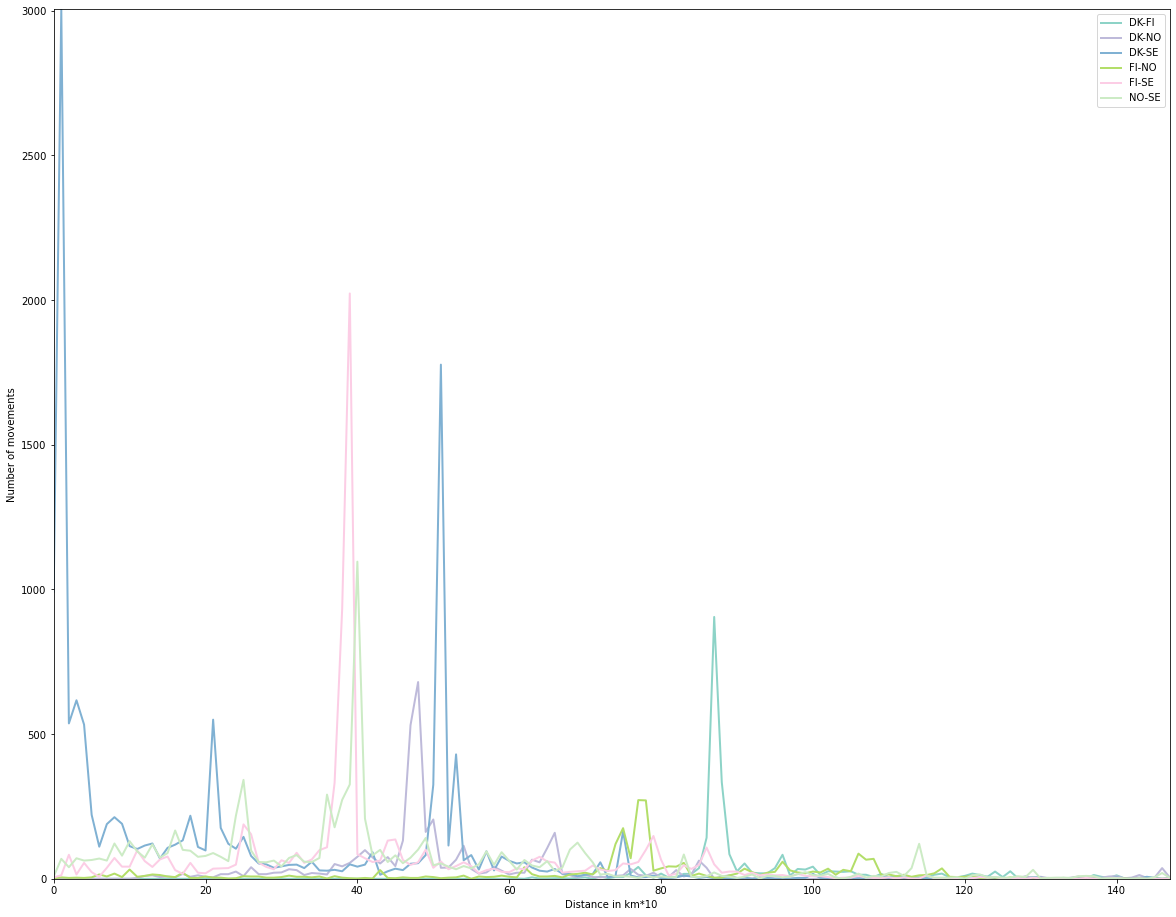

In [16]:
bins_list = list(np.arange(10,1500,10))
fig, ax = plt.subplots(figsize=(20,16))
ax.set_ylabel("Number of movements")
ax.set_xlabel("Distance in km*10")

ax = plt.plot(list(pre_dk_fi['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='DK-FI', color='#8dd3c7')
ax = plt.plot(list(pre_dk_no['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='DK-NO', color='#bebada')
ax = plt.plot(list(pre_dk_sw['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='DK-SE', color='#80b1d3')
ax = plt.plot(list(pre_fi_no['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='FI-NO', color='#b3de69')
ax = plt.plot(list(pre_fi_sw['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='FI-SE', color='#fccde5')
ax = plt.plot(list(pre_no_sw['distance_km'].value_counts(bins=bins_list).sort_index()), linewidth=2, label='NO-SE', color='#ccebc5')
# Iceland
#ax = plt.plot(list(pre_dk_ic['distance_km'].value_counts(bins=bins_list).sort_index()), label='DK-IS', color='#2d004b')
#ax = plt.plot(list(pre_fi_ic['distance_km'].value_counts(bins=bins_list).sort_index()), label='FI-IS', color='#fdb462')
#ax = plt.plot(list(pre_ic_no['distance_km'].value_counts(bins=bins_list).sort_index()), label='IS-NO', color='#d9d9d9')
#ax = plt.plot(list(pre_ic_sw['distance_km'].value_counts(bins=bins_list).sort_index()), label='IS-SE', color='#bc80bd')

plt.margins(0)
plt.legend()
#plt.savefig('../imgs/distances_lines.png', dpi=150)
plt.show()

## COVID-19 lines

In [17]:
print('--- COVID-19 lines ---')
# SQL-query
query = 'SELECT geometry,user_id,dest_country,orig_time,dest_time,duration,post_region,dest_region,region_move,cb_move,distance_km,row_id,country_code FROM post_covid_lines'
# Read data to dataframe
post_lines = db_con.read_sql_inmem_uncompressed(query, db_engine)
# Apply wkt
post_lines['geometry'] = post_lines['geometry'].apply(wkt.loads)
# Convert to GeoDataFrame
post_lines_gdf = gpd.GeoDataFrame(post_lines, geometry='geometry')
# CRS
post_lines_gdf.crs = "EPSG:4326"
# Delete dataframe
del post_lines
# Convert timestamps
post_lines_gdf['orig_time'] = post_lines_gdf['orig_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
post_lines_gdf['dest_time'] = post_lines_gdf['dest_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
# Add month
post_lines_gdf['month'] = post_lines_gdf['dest_time'].apply(lambda x: x.month)
post_lines_gdf['yearmonth'] = post_lines_gdf['dest_time'].apply(lambda x: int(str(x.year)+str(x.month).zfill(2)))
# Add day of week
post_lines_gdf['orig_day_of_week'] = post_lines_gdf['orig_time'].apply(lambda x: x.dayofweek)
post_lines_gdf['dest_day_of_week'] = post_lines_gdf['dest_time'].apply(lambda x: x.dayofweek)

print(f"Number of movements: {len(pre_lines_gdf)}")
print(f"Number of users: {post_lines_gdf['user_id'].nunique()}")
print(f"Median number of travels: {post_lines_gdf['user_id'].value_counts().median()}")

--- COVID-19 lines ---
Number of movements: 44126
Number of users: 3792
Median number of travels: 2.0


In [18]:
post_dk_fi = post_lines_gdf[post_lines_gdf['cb_move'].str.match('DK-FI|FI-DK')]
post_dk_ic = post_lines_gdf[post_lines_gdf['cb_move'].str.match('DK-IS|IS-DK')]
post_dk_no = post_lines_gdf[post_lines_gdf['cb_move'].str.match('DK-NO|NO-DK')]
post_dk_sw = post_lines_gdf[post_lines_gdf['cb_move'].str.match('DK-SE|SE-DK')]
post_fi_ic = post_lines_gdf[post_lines_gdf['cb_move'].str.match('FI-IS|IS-FI')]
post_fi_no = post_lines_gdf[post_lines_gdf['cb_move'].str.match('FI-NO|NO-FI')]
post_fi_sw = post_lines_gdf[post_lines_gdf['cb_move'].str.match('FI-SE|SE-FI')]
post_ic_no = post_lines_gdf[post_lines_gdf['cb_move'].str.match('IS-NO|NO-IS')]
post_ic_sw = post_lines_gdf[post_lines_gdf['cb_move'].str.match('IS-SE|SE-IS')]
post_no_sw = post_lines_gdf[post_lines_gdf['cb_move'].str.match('NO-SE|SE-NO')]
print('--- Length of country crossings ---')
print(f"Lines between DK-FI: {len(post_dk_fi)}")
print(f"Lines between DK-IS: {len(post_dk_ic)}")
print(f"Lines between DK-NO: {len(post_dk_no)}")
print(f"Lines between DK-SE: {len(post_dk_sw)}")
print(f"Lines between FI-IS: {len(post_fi_ic)}")
print(f"Lines between FI-NO: {len(post_fi_no)}")
print(f"Lines between FI-SE: {len(post_fi_sw)}")
print(f"Lines between IS-NO: {len(post_ic_no)}")
print(f"Lines between IS-SE: {len(post_ic_sw)}")
print(f"Lines between NO-SE: {len(post_no_sw)}")

--- Length of country crossings ---
Lines between DK-FI: 408
Lines between DK-IS: 282
Lines between DK-NO: 1066
Lines between DK-SE: 3309
Lines between FI-IS: 171
Lines between FI-NO: 944
Lines between FI-SE: 1652
Lines between IS-NO: 613
Lines between IS-SE: 276
Lines between NO-SE: 2044


### Distances 

In [19]:
print('--- Post-COVID-19 distance median ---')
print(f"Median distance for total: {round(post_lines_gdf['distance_km'].median(),2)}")
print('--- Distance median for countries ---')
print(f"Median distance between DK-FI: {round(post_dk_fi['distance_km'].median(),2)}")
print(f"Median distance between DK-IS: {round(post_dk_ic['distance_km'].median(),2)}")
print(f"Median distance between DK-NO: {round(post_dk_no['distance_km'].median(),2)}")
print(f"Median distance between DK-SE: {round(post_dk_sw['distance_km'].median(),2)}")
print(f"Median distance between FI-IS: {round(post_fi_ic['distance_km'].median(),2)}")
print(f"Median distance between FI-NO: {round(post_fi_no['distance_km'].median(),2)}")
print(f"Median distance between FI-SE: {round(post_fi_sw['distance_km'].median(),2)}")
print(f"Median distance between IS-NO: {round(post_ic_no['distance_km'].median(),2)}")
print(f"Median distance between IS-SE: {round(post_ic_sw['distance_km'].median(),2)}")
print(f"Median distance between NO-SE: {round(post_no_sw['distance_km'].median(),2)}")

--- Post-COVID-19 distance median ---
Median distance for total: 483.98
--- Distance median for countries ---
Median distance between DK-FI: 904.13
Median distance between DK-IS: 1974.64
Median distance between DK-NO: 508.98
Median distance between DK-SE: 106.77
Median distance between FI-IS: 2158.52
Median distance between FI-NO: 818.94
Median distance between FI-SE: 404.66
Median distance between IS-NO: 1481.46
Median distance between IS-SE: 1977.73
Median distance between NO-SE: 413.7


### Unique users in both line datasets

In [20]:
pre_lines_user_list = list(pre_lines_gdf['user_id'].unique())
post_lines_user_list = list(post_lines_gdf['user_id'].unique())
unique_lines_combined = pre_lines_user_list + list(set(post_lines_user_list) - set(pre_lines_user_list))
print(f"Number of unique users over both line datasets: {len(unique_lines_combined)}")

Number of unique users over both line datasets: 19996


## Temporal Explorations

### Duration of travel

In [21]:
print('--- Duration, mean and median, pre-COVID-19 and COVID-19 ---')
print(f"Mean duration of pre-COVID-19: {round(pre_lines_gdf['duration'].mean(),2)}")
print(f"Median duration of pre-COVID-19: {round(pre_lines_gdf['duration'].median(),2)}")
print(f"Mean duration of COVID-19: {round(post_lines_gdf['duration'].mean(),2)}")
print(f"Median duration of COVID-19: {round(post_lines_gdf['duration'].median(),2)}")

--- Duration, mean and median, pre-COVID-19 and COVID-19 ---
Mean duration of pre-COVID-19: 18.84
Median duration of pre-COVID-19: 3.0
Mean duration of COVID-19: 17.45
Median duration of COVID-19: 3.0


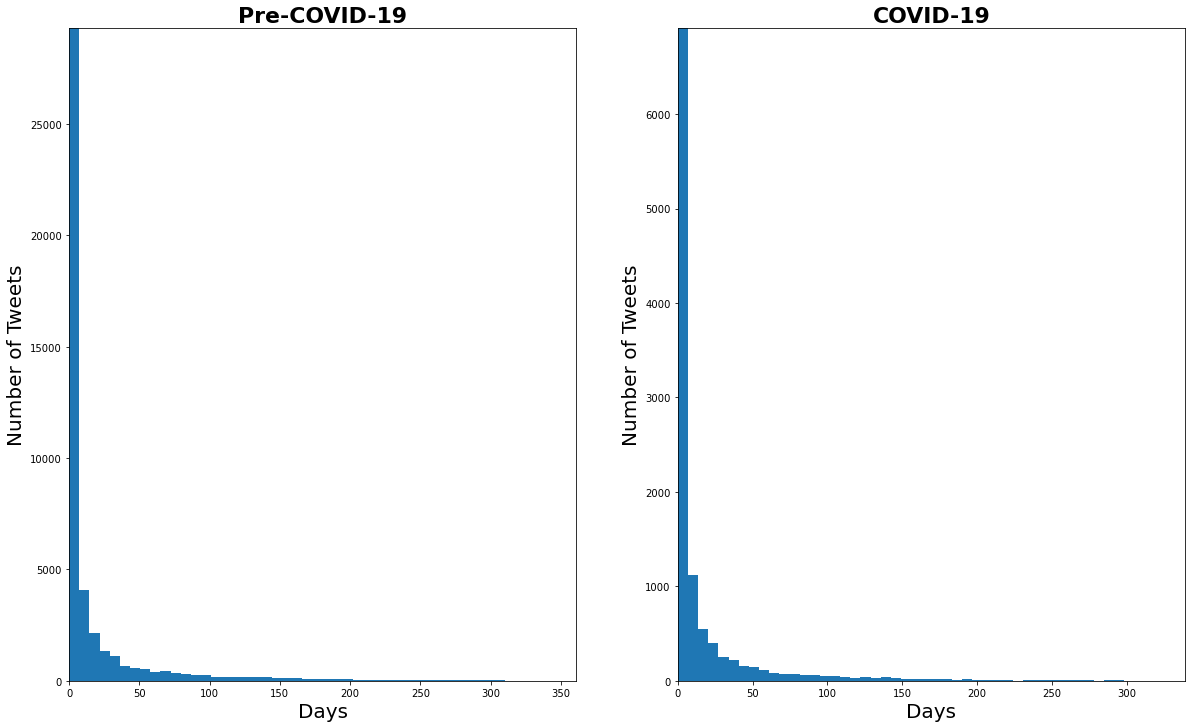

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
pre_lines_gdf['duration'].plot(ax = axes[0], kind='hist', bins=50)
post_lines_gdf['duration'].plot(ax = axes[1], kind='hist', bins=50)

axes[0].set_title("Pre-COVID-19", fontweight='bold', fontsize=22)
axes[0].set_xlabel("Days", fontsize=20)
axes[0].set_ylabel("Number of Tweets", fontsize=20)
#axes[0].set_yscale('log')
axes[0].margins(0)
axes[1].set_title("COVID-19", fontweight='bold', fontsize=22)
axes[1].set_xlabel("Days", fontsize=20)
axes[1].set_ylabel("Number of Tweets", fontsize=20)
#axes[1].set_yscale('log')
axes[1].margins(0)
#plt.savefig("../imgs/duration_histogram.png",dpi=150)
plt.show()

### Weekdays

In [23]:
def dayAverages(df):
    mondays = 0
    tuesdays = 0
    wednesdays = 0
    thursdays = 0
    fridays = 0
    saturdays = 0
    sundays = 0

    # Iterate over a LineString dataset, calculate average weekdays and variance
    for index, row in df.iterrows():

        # Store weekdays from trip endpoints, convert to timestamps
        day_name_orig = row['orig_day_of_week']
        day_name_dest = row['dest_day_of_week']

        # Count weekdays
        if any( [day_name_orig == 0, day_name_dest == 0] ):
            mondays += 1

        if any( [day_name_orig == 1, day_name_dest == 1] ):
            tuesdays += 1

        if any( [day_name_orig == 2, day_name_dest == 2] ):
            wednesdays += 1

        if any( [day_name_orig == 3, day_name_dest == 3] ):
            thursdays += 1

        if any( [day_name_orig == 4, day_name_dest == 4] ):
            fridays += 1

        if any( [day_name_orig == 5, day_name_dest == 5] ):
            saturdays += 1

        if any( [day_name_orig == 6, day_name_dest == 6] ):
            sundays += 1

    avg = (mondays + tuesdays + wednesdays + thursdays + fridays + saturdays + sundays) / 7
    averages = {'average': avg, 'mondays': ((mondays/avg)*100)-100, 'tuesdays': ((tuesdays/avg)*100)-100, 'wednesdays': ((wednesdays/avg)*100)-100, 'thursdays': ((thursdays/avg)*100)-100, 'fridays': ((fridays/avg)*100)-100, 'saturdays': ((saturdays/avg)*100)-100, 'sundays': ((sundays/avg)*100)-100}
    diffs = [((mondays/avg)*100)-100,((tuesdays/avg)*100)-100,((wednesdays/avg)*100)-100,((thursdays/avg)*100)-100,((fridays/avg)*100)-100,((saturdays/avg)*100)-100,((sundays/avg)*100)-100]
    return averages, diffs

### Line chart

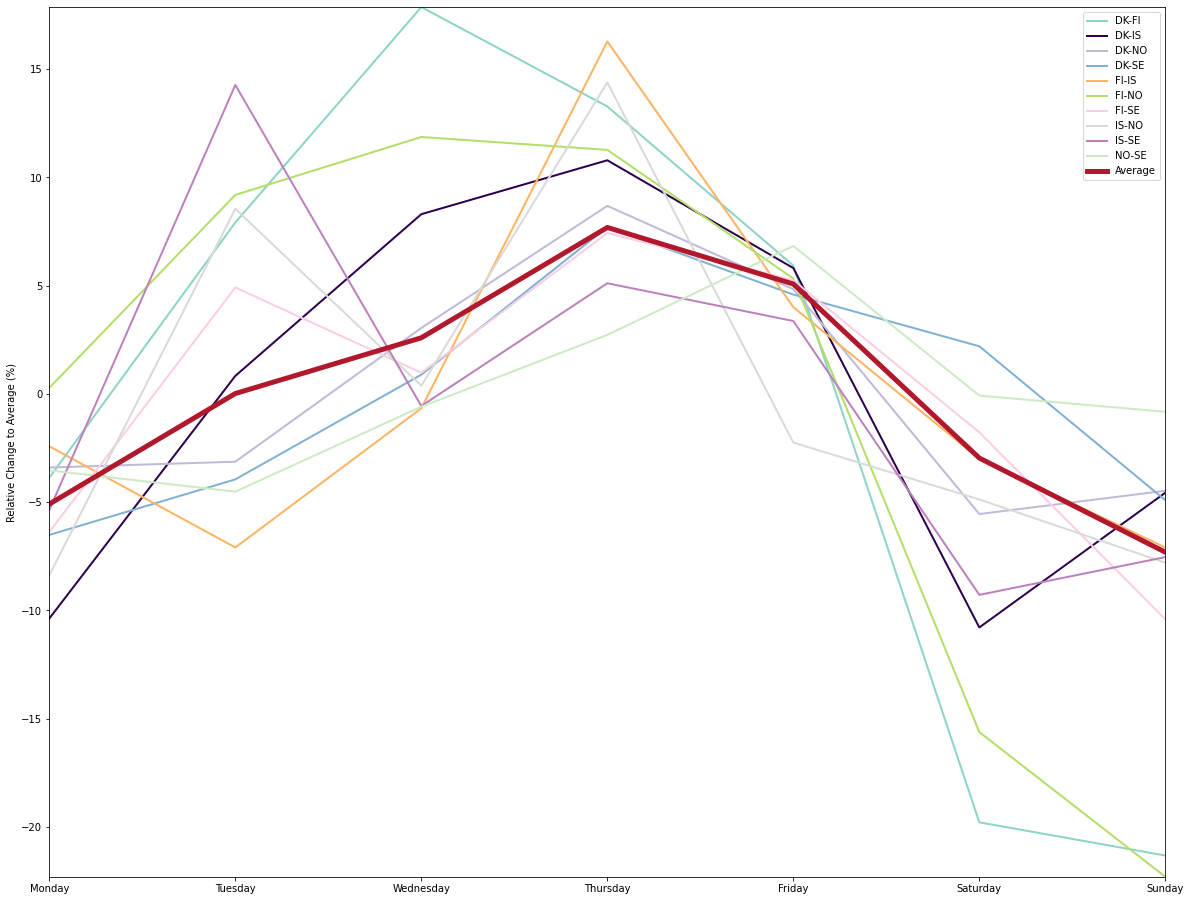

In [24]:
fig, ax = plt.subplots(figsize=(20,16))
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax.set_ylabel("Relative Change to Average (%)")


ax = plt.plot(weekdays, dayAverages(pre_dk_fi)[1], linewidth=2, label='DK-FI', color='#8dd3c7')
ax = plt.plot(weekdays, dayAverages(pre_dk_ic)[1], linewidth=2, label='DK-IS', color='#2d004b')
ax = plt.plot(weekdays, dayAverages(pre_dk_no)[1], linewidth=2, label='DK-NO', color='#bebada')
ax = plt.plot(weekdays, dayAverages(pre_dk_sw)[1], linewidth=2, label='DK-SE', color='#80b1d3')
ax = plt.plot(weekdays, dayAverages(pre_fi_ic)[1], linewidth=2, label='FI-IS', color='#fdb462')
ax = plt.plot(weekdays, dayAverages(pre_fi_no)[1], linewidth=2, label='FI-NO', color='#b3de69')
ax = plt.plot(weekdays, dayAverages(pre_fi_sw)[1], linewidth=2, label='FI-SE', color='#fccde5')
ax = plt.plot(weekdays, dayAverages(pre_ic_no)[1], linewidth=2, label='IS-NO', color='#d9d9d9')
ax = plt.plot(weekdays, dayAverages(pre_ic_sw)[1], linewidth=2, label='IS-SE', color='#bc80bd')
ax = plt.plot(weekdays, dayAverages(pre_no_sw)[1], linewidth=2, label='NO-SE', color='#ccebc5')
ax = plt.plot(weekdays, dayAverages(pre_lines_gdf)[1], linewidth=5, label='Average', color='#b2182b')
plt.legend()
plt.margins(0)
#plt.savefig("../imgs/weekdays_lines.png",dpi=150)
plt.show()

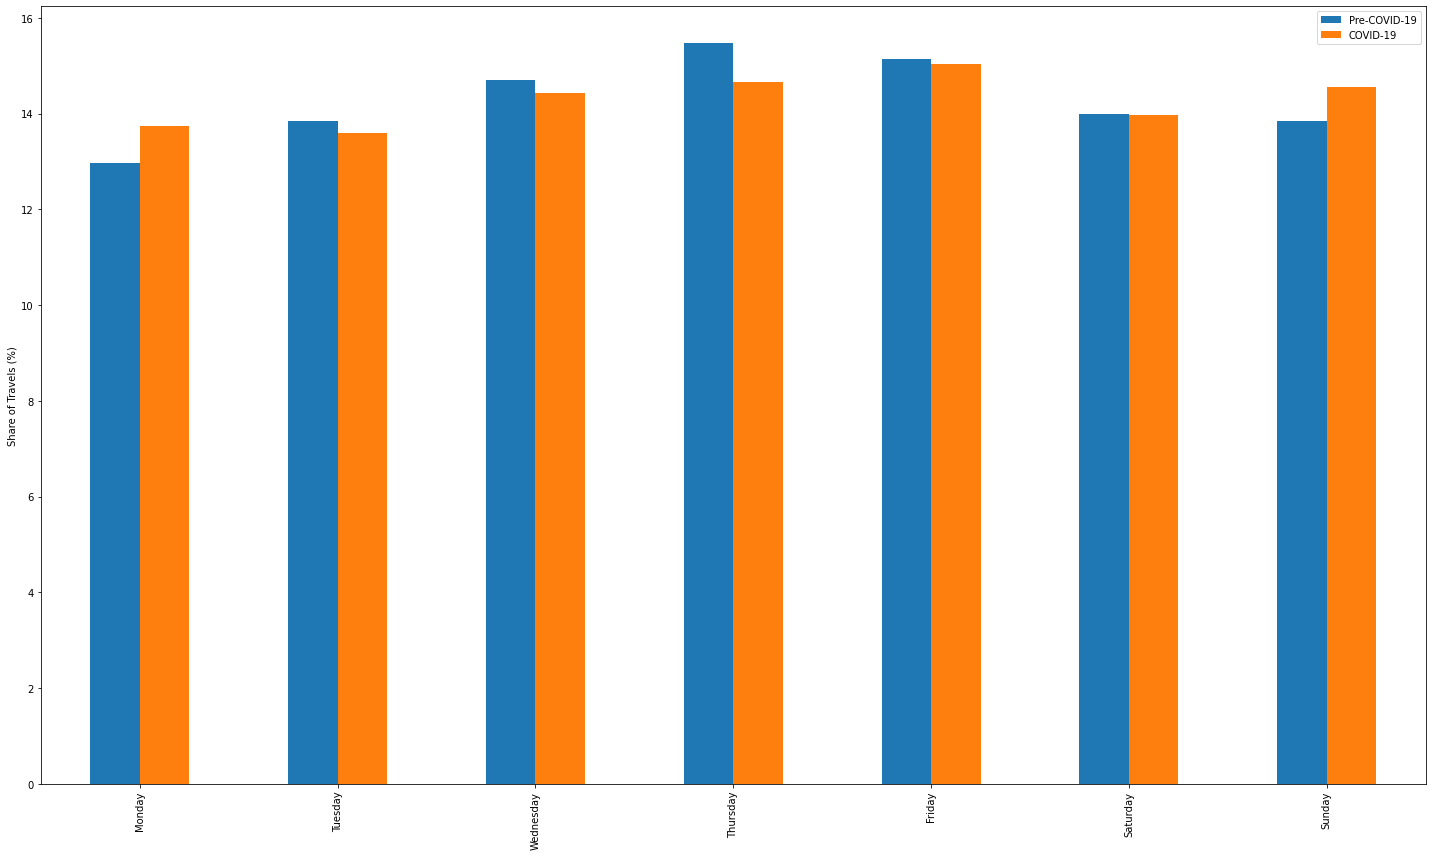

In [25]:
pre_days = list(pre_lines_gdf['orig_day_of_week'].value_counts().sort_index())
post_days = list(post_lines_gdf['orig_day_of_week'].value_counts().sort_index())

days_df = pd.DataFrame()
days_df['Pre-COVID_total'] = pre_days
days_df['Pre-COVID-19'] = (days_df['Pre-COVID_total'] / days_df['Pre-COVID_total'].sum()) * 100
days_df['COVID_total'] = post_days
days_df['COVID-19'] = (days_df['COVID_total'] / days_df['COVID_total'].sum()) * 100
days_df = days_df[['Pre-COVID-19','COVID-19']]
ax = days_df.plot.bar(figsize=(20,12))


ax.set_ylabel("Share of Travels (%)")
weeklabels = ['Monday','Tuesday','Wednesday','Thursday', 'Friday','Saturday','Sunday']
x = np.arange(len(weeklabels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(weeklabels)
ax.plot()
plt.tight_layout()
#plt.savefig("../imgs/weekdays.png",dpi=150)
plt.show()

### Months

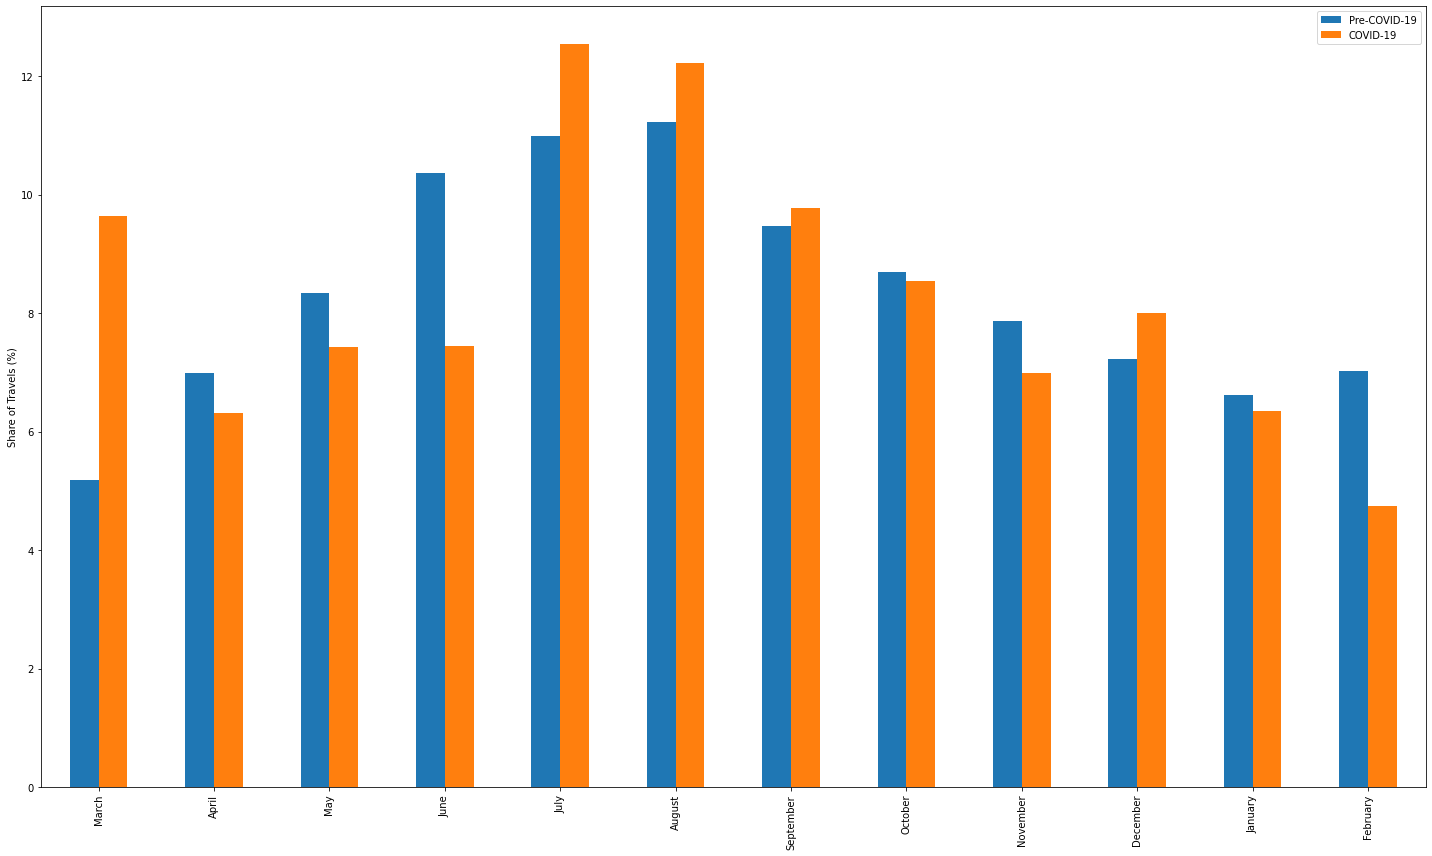

In [26]:
# Get movements per month
pre_months = list(pre_lines_gdf['yearmonth'].value_counts(sort=False).sort_index())
post_months = list(post_lines_gdf['yearmonth'].value_counts().sort_index())

# Combine datasets and get share of total travels
months_df = pd.DataFrame()
months_df['Pre-COVID-19_total'] = pre_months
months_df['Pre-COVID-19'] = (months_df['Pre-COVID-19_total'] / months_df['Pre-COVID-19_total'].sum()) * 100
months_df['COVID-19_total'] = post_months
months_df['COVID-19'] = (months_df['COVID-19_total'] / months_df['COVID-19_total'].sum()) * 100
months_df = months_df[['Pre-COVID-19','COVID-19']]

# Plot
ax = months_df.plot.bar(figsize=(20,12))
ax.set_ylabel("Share of Travels (%)")
monthlabels = ['March','April','May','June','July','August','September','October','November','December','January','February']
x = np.arange(len(monthlabels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(monthlabels)
ax.plot()
plt.tight_layout()
#plt.savefig("../imgs/months.png",dpi=150)
plt.show()

#### Months all countries

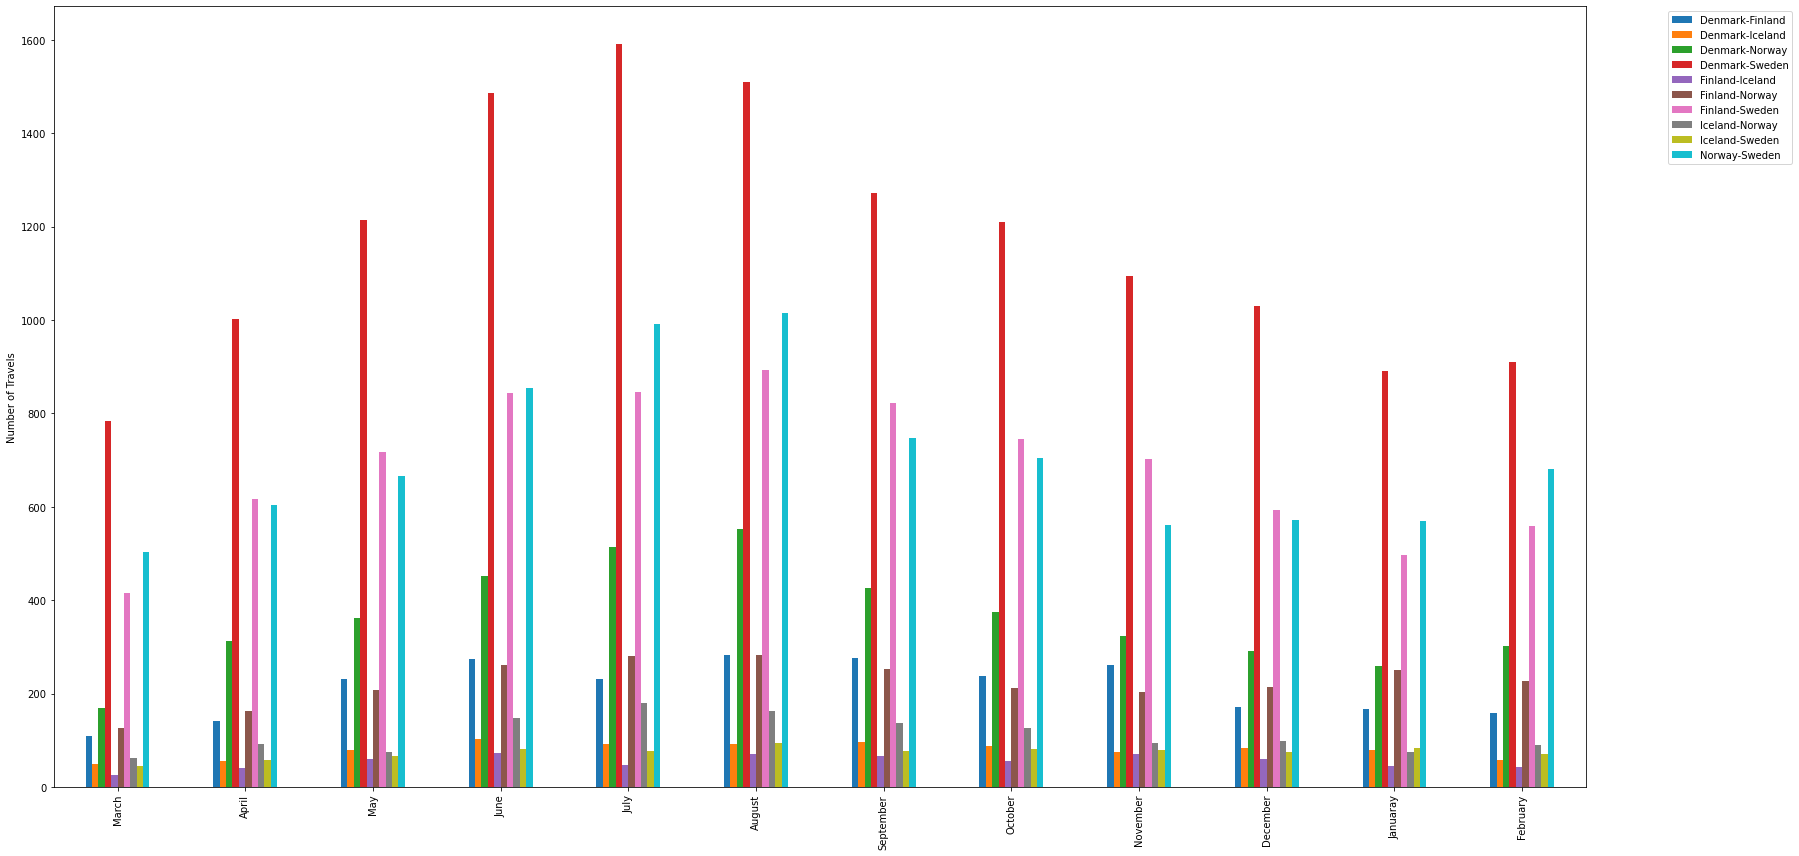

In [27]:
# Pre-COVID-19
# Get monthly travels per country pair
pre_months_dk_fi = list(pre_dk_fi['yearmonth'].value_counts().sort_index())
pre_months_dk_ic = list(pre_dk_ic['yearmonth'].value_counts().sort_index())
pre_months_dk_no = list(pre_dk_no['yearmonth'].value_counts().sort_index())
pre_months_dk_sw = list(pre_dk_sw['yearmonth'].value_counts().sort_index())
pre_months_fi_ic = list(pre_fi_ic['yearmonth'].value_counts().sort_index())
pre_months_fi_no = list(pre_fi_no['yearmonth'].value_counts().sort_index())
pre_months_fi_sw = list(pre_fi_sw['yearmonth'].value_counts().sort_index())
pre_months_ic_no = list(pre_ic_no['yearmonth'].value_counts().sort_index())
pre_months_ic_sw = list(pre_ic_sw['yearmonth'].value_counts().sort_index())
pre_months_no_sw = list(pre_no_sw['yearmonth'].value_counts().sort_index())
pre_months_all_df = pd.DataFrame()
pre_months_all_df['Denmark-Finland'] = pre_months_dk_fi
pre_months_all_df['Denmark-Iceland'] = pre_months_dk_ic
pre_months_all_df['Denmark-Norway'] = pre_months_dk_no
pre_months_all_df['Denmark-Sweden'] = pre_months_dk_sw
pre_months_all_df['Finland-Iceland'] = pre_months_fi_ic
pre_months_all_df['Finland-Norway'] = pre_months_fi_no
pre_months_all_df['Finland-Sweden'] = pre_months_fi_sw
pre_months_all_df['Iceland-Norway'] = pre_months_ic_no
pre_months_all_df['Iceland-Sweden'] = pre_months_ic_sw
pre_months_all_df['Norway-Sweden'] = pre_months_no_sw

# Plot
ax = pre_months_all_df.plot.bar(figsize=(25,12))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Number of Travels")
monthlabels = ['March','April','May','June','July','August','September','October','November','December','Januaray','February']
x = np.arange(len(monthlabels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(monthlabels)
ax.plot()
plt.tight_layout()
#plt.savefig("../imgs/pre_months_all.png",dpi=150)

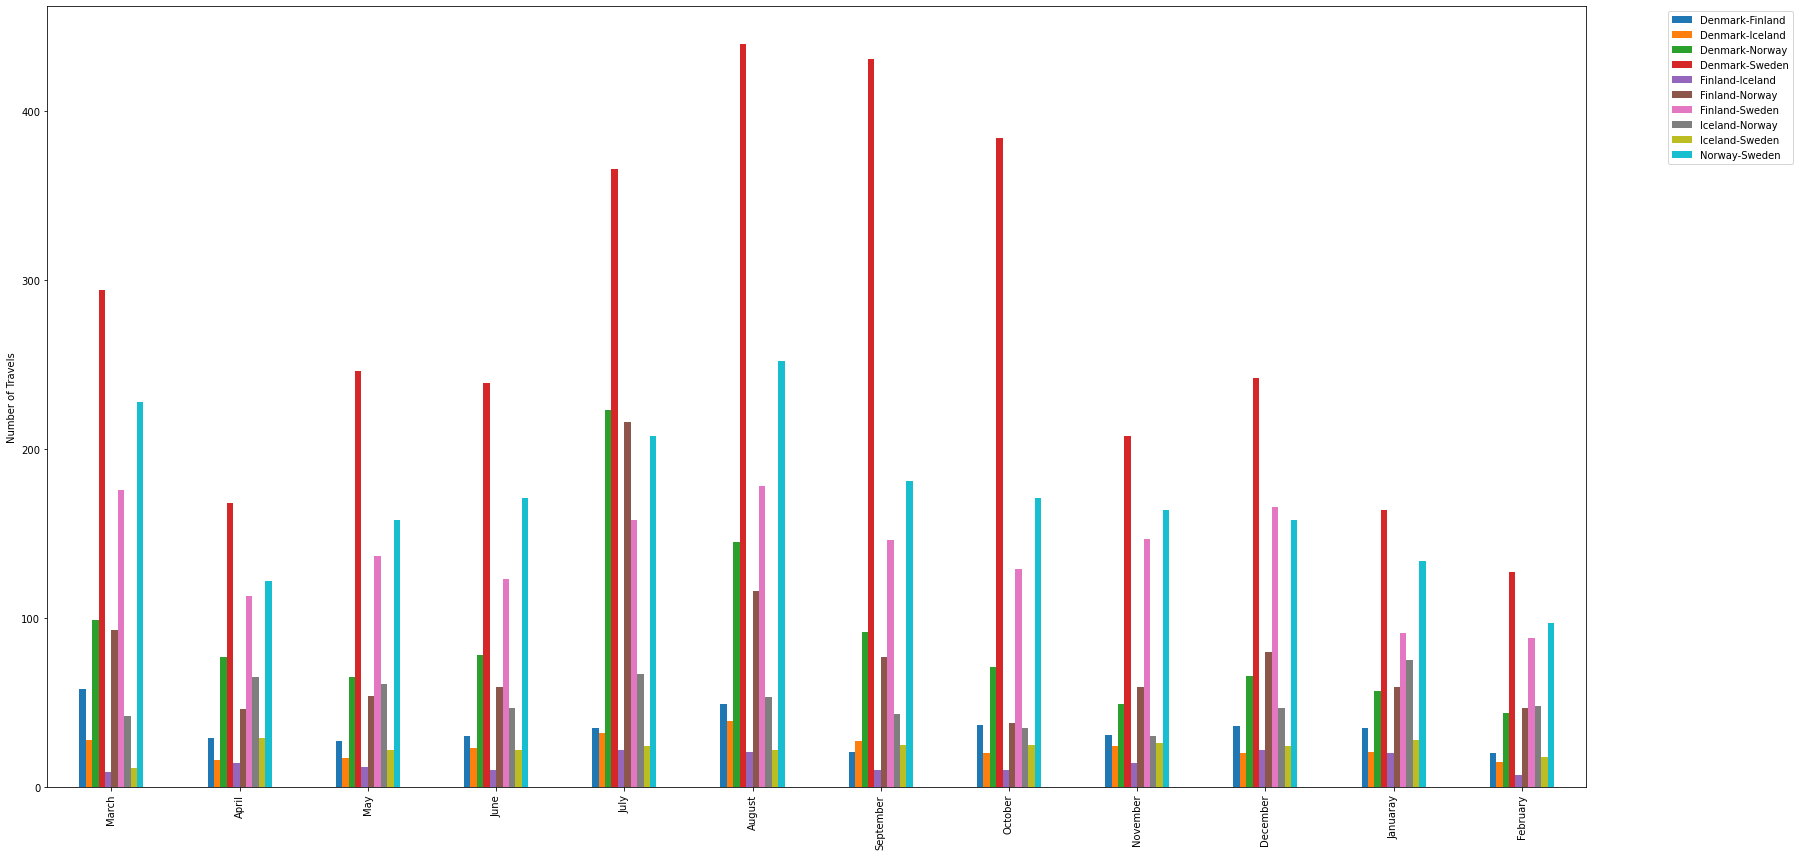

In [28]:
# COVID-19
# Get monthly travels per country pair
post_months_dk_fi = list(post_dk_fi['yearmonth'].value_counts().sort_index())
post_months_dk_ic = list(post_dk_ic['yearmonth'].value_counts().sort_index())
post_months_dk_no = list(post_dk_no['yearmonth'].value_counts().sort_index())
post_months_dk_sw = list(post_dk_sw['yearmonth'].value_counts().sort_index())
post_months_fi_ic = list(post_fi_ic['yearmonth'].value_counts().sort_index())
post_months_fi_no = list(post_fi_no['yearmonth'].value_counts().sort_index())
post_months_fi_sw = list(post_fi_sw['yearmonth'].value_counts().sort_index())
post_months_ic_no = list(post_ic_no['yearmonth'].value_counts().sort_index())
post_months_ic_sw = list(post_ic_sw['yearmonth'].value_counts().sort_index())
post_months_no_sw = list(post_no_sw['yearmonth'].value_counts().sort_index())
post_months_all_df = pd.DataFrame()
post_months_all_df['Denmark-Finland'] = post_months_dk_fi
post_months_all_df['Denmark-Iceland'] = post_months_dk_ic
post_months_all_df['Denmark-Norway'] = post_months_dk_no
post_months_all_df['Denmark-Sweden'] = post_months_dk_sw
post_months_all_df['Finland-Iceland'] = post_months_fi_ic
post_months_all_df['Finland-Norway'] = post_months_fi_no
post_months_all_df['Finland-Sweden'] = post_months_fi_sw
post_months_all_df['Iceland-Norway'] = post_months_ic_no
post_months_all_df['Iceland-Sweden'] = post_months_ic_sw
post_months_all_df['Norway-Sweden'] = post_months_no_sw

# Plot
ax = post_months_all_df.plot.bar(figsize=(25,12))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Number of Travels")
monthlabels = ['March','April','May','June','July','August','September','October','November','December','Januaray','February']
x = np.arange(len(monthlabels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(monthlabels)
ax.plot()
plt.tight_layout()
#plt.savefig("../imgs/post_months_all.png",dpi=150)

### Month lines

In [29]:
def monthAverages(df):
    """Get difference from average monthly travel
    
    """
    avg = len(df)/12
    diffs = (((df['month'].value_counts()/avg)*100)-100).sort_index()
    diffs_order = diffs[2:].append(diffs[:2])
    return diffs_order

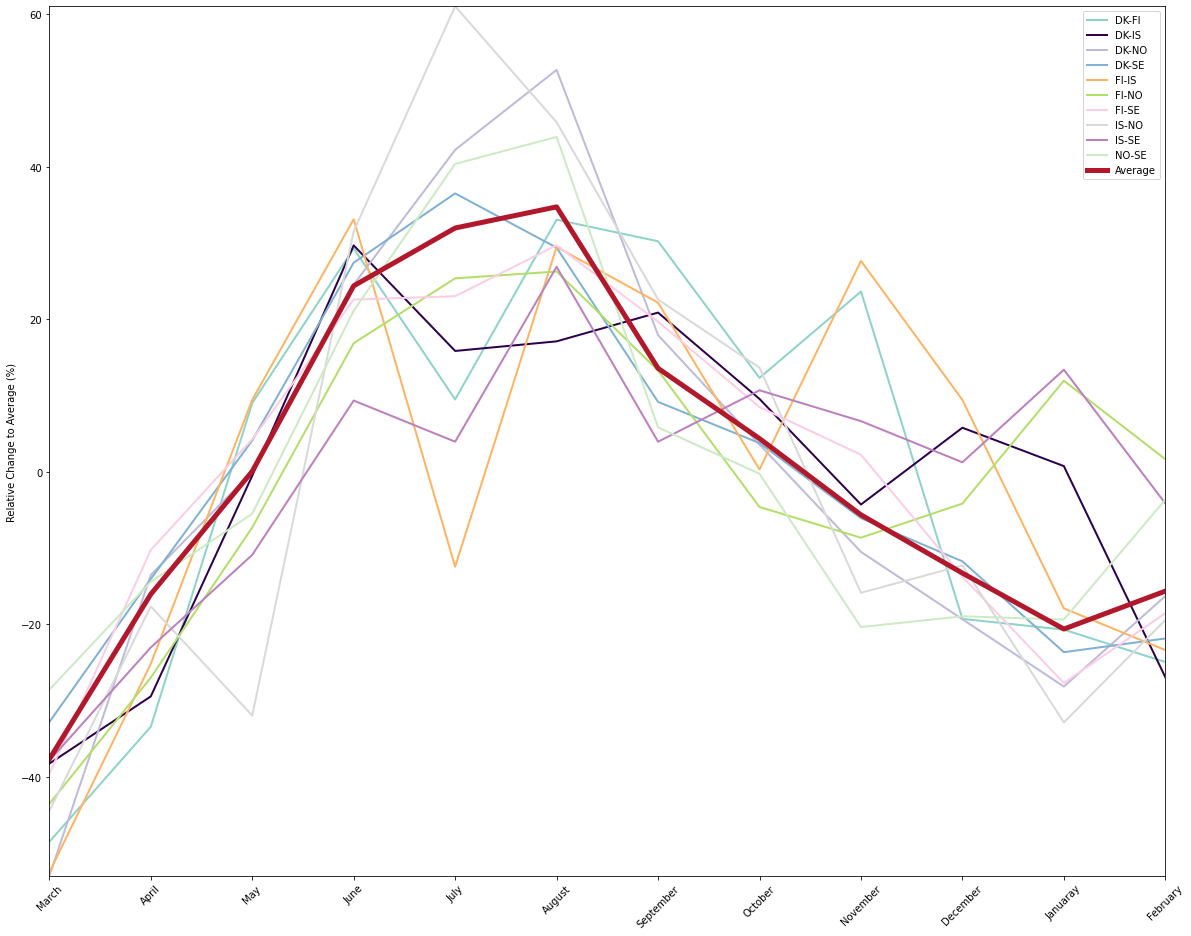

In [30]:
# Plot
fig, ax = plt.subplots(figsize=(20,16))
monthlabels = ['March','April','May','June','July','August','September','October','November','December','Januaray','February']
ax.set_ylabel("Relative Change to Average (%)")
x = np.arange(len(monthlabels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(monthlabels)
plt.xticks(rotation = 45)
# Add country pairs
ax = plt.plot(monthlabels, monthAverages(pre_dk_fi), linewidth=2, label='DK-FI', color='#8dd3c7')
ax = plt.plot(monthlabels, monthAverages(pre_dk_ic), linewidth=2, label='DK-IS', color='#2d004b')
ax = plt.plot(monthlabels, monthAverages(pre_dk_no), linewidth=2, label='DK-NO', color='#bebada')
ax = plt.plot(monthlabels, monthAverages(pre_dk_sw), linewidth=2, label='DK-SE', color='#80b1d3')
ax = plt.plot(monthlabels, monthAverages(pre_fi_ic), linewidth=2, label='FI-IS', color='#fdb462')
ax = plt.plot(monthlabels, monthAverages(pre_fi_no), linewidth=2, label='FI-NO', color='#b3de69')
ax = plt.plot(monthlabels, monthAverages(pre_fi_sw), linewidth=2, label='FI-SE', color='#fccde5')
ax = plt.plot(monthlabels, monthAverages(pre_ic_no), linewidth=2, label='IS-NO', color='#d9d9d9')
ax = plt.plot(monthlabels, monthAverages(pre_ic_sw), linewidth=2, label='IS-SE', color='#bc80bd')
ax = plt.plot(monthlabels, monthAverages(pre_no_sw), linewidth=2, label='NO-SE', color='#ccebc5')
ax = plt.plot(monthlabels, monthAverages(pre_lines_gdf), linewidth=5, label='Average', color='#b2182b')
plt.legend()
plt.margins(0)
#plt.savefig("../imgs/months_lines.png",dpi=150)
plt.show()

# Comparison to Nordic Data

In [31]:
# Combine line data
combined_lines = pre_lines_gdf.append(post_lines_gdf)

In [32]:
print('--- Pre-COVID-19 From Denmark ---')
pre_from_dk = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('DK-FI|DK-SE|DK-NO|DK-IS')]
pre_dk_mo = round(pre_from_dk['cb_move'].value_counts(normalize=True)*100,2)
print(pre_dk_mo)

print('--- COVID-19 From Denmark ---')
post_from_dk = post_lines_gdf[post_lines_gdf['cb_move'].str.match('DK-FI|DK-SE|DK-NO|DK-IS')]
post_dk_mo = round(post_from_dk['cb_move'].value_counts(normalize=True)*100,2)
print(post_dk_mo)

print('--- Pre-COVID-19 From Finland ---')
pre_from_fi = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('FI-DK|FI-SE|FI-NO|FI-IS')]
pre_fi_mo = round(pre_from_fi['cb_move'].value_counts(normalize=True)*100,2)
print(pre_fi_mo)

print('--- COVID-19 From Finland ---')
post_from_fi = post_lines_gdf[post_lines_gdf['cb_move'].str.match('FI-DK|FI-SE|FI-NO|FI-IS')]
post_fi_mo = round(post_from_fi['cb_move'].value_counts(normalize=True)*100,2)
print(post_fi_mo)

print('--- Pre-COVID-19 From Iceland ---')
pre_from_is = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('IS-FI|IS-SE|IS-NO|IS-DK')]
pre_is_mo = round(pre_from_is['cb_move'].value_counts(normalize=True)*100,2)
print(pre_is_mo)

print('--- COVID-19 From Iceland ---')
post_from_is = post_lines_gdf[post_lines_gdf['cb_move'].str.match('IS-FI|IS-SE|IS-NO|IS-DK')]
post_is_mo = round(post_from_is['cb_move'].value_counts(normalize=True)*100,2)
print(post_is_mo)

print('--- Pre-COVID-19 From Norway ---')
pre_from_no = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('NO-FI|NO-SE|NO-DK|NO-IS')]
pre_no_mo = round(pre_from_no['cb_move'].value_counts(normalize=True)*100,2)
print(pre_no_mo)

print('--- COVID-19 From Norway ---')
post_from_no = post_lines_gdf[post_lines_gdf['cb_move'].str.match('NO-FI|NO-SE|NO-DK|NO-IS')]
post_no_mo = round(post_from_no['cb_move'].value_counts(normalize=True)*100,2)
print(post_no_mo)

print('--- Pre-COVID-19 From Sweden ---')
pre_from_sw = pre_lines_gdf[pre_lines_gdf['cb_move'].str.match('SE-FI|SE-DK|SE-NO|SE-IS')]
pre_sw_mo = round(pre_from_sw['cb_move'].value_counts(normalize=True)*100,2)
print(pre_sw_mo)

print('--- COVID-19 From Sweden ---')
post_from_sw = post_lines_gdf[post_lines_gdf['cb_move'].str.match('SE-FI|SE-DK|SE-NO|SE-IS')]
post_sw_mo = round(post_from_sw['cb_move'].value_counts(normalize=True)*100,2)
print(post_sw_mo)


--- Pre-COVID-19 From Denmark ---
DK-SE    63.79
DK-NO    20.32
DK-FI    11.62
DK-IS     4.27
Name: cb_move, dtype: float64
--- COVID-19 From Denmark ---
DK-SE    65.42
DK-NO    20.97
DK-FI     8.16
DK-IS     5.45
Name: cb_move, dtype: float64
--- Pre-COVID-19 From Finland ---
FI-SE    58.04
FI-NO    19.26
FI-DK    18.04
FI-IS     4.66
Name: cb_move, dtype: float64
--- COVID-19 From Finland ---
FI-SE    52.89
FI-NO    29.27
FI-DK    12.64
FI-IS     5.20
Name: cb_move, dtype: float64
--- Pre-COVID-19 From Iceland ---
IS-NO    34.56
IS-DK    25.04
IS-SE    23.28
IS-FI    17.12
Name: cb_move, dtype: float64
--- COVID-19 From Iceland ---
IS-NO    45.77
IS-DK    20.95
IS-SE    19.91
IS-FI    13.37
Name: cb_move, dtype: float64
--- Pre-COVID-19 From Norway ---
NO-SE    50.95
NO-DK    25.17
NO-FI    15.85
NO-IS     8.03
Name: cb_move, dtype: float64
--- COVID-19 From Norway ---
NO-SE    43.91
NO-DK    22.32
NO-FI    20.78
NO-IS    12.99
Name: cb_move, dtype: float64
--- Pre-COVID-19 From Swed

In [33]:
# Read official statistics
nordic_comm12 = pd.read_csv('COMM12_20210411-172228.csv', header=1, na_values='.')
# Subset to wanted columns
nordic_comm12 = nordic_comm12[['region of residence','2015 Denmark (country of work) All industries','2015 Finland (country of work) All industries','2015 Iceland (country of work) All industries','2015 Norway (country of work) All industries','2015 Sweden (country of work) All industries']]
# Rename columns
nordic_comm12 = nordic_comm12.rename(columns = {'2015 Denmark (country of work) All industries':'DK','2015 Finland (country of work) All industries': 'FI','2015 Iceland (country of work) All industries':'IS','2015 Norway (country of work) All industries':'NO','2015 Sweden (country of work) All industries':'SE'})
# Subset
nordic_comm12 = nordic_comm12[0:5]
# Clean
nordic_comm12 = nordic_comm12.fillna(0)
nordic_comm12['region of residence'] = nordic_comm12['region of residence'].apply(lambda x: x[0:2])
nordic_comm12 = nordic_comm12.set_index('region of residence')

display(nordic_comm12)

,DK,FI,IS,NO,SE
region of residence,,,,,
DK,0.0,179.0,195.0,3596.0,1750.0
FI,101.0,0.0,13.0,966.0,1276.0
IS,56.0,12.0,0.0,694.0,88.0
NO,503.0,184.0,140.0,0.0,925.0
SE,15795.0,1854.0,165.0,22742.0,0.0


In [34]:
# Lists for bidirectional travels
nordic_list_bidirectional = [280,251,4099,17545,25,1150,3130,834,253,23667]
pre_list_bidirectional = [len(pre_dk_fi),len(pre_dk_ic),len(pre_dk_no),len(pre_dk_sw),len(pre_fi_ic),len(pre_fi_no),len(pre_fi_sw),len(pre_ic_no),len(pre_ic_sw),len(pre_no_sw)]
post_list_bidirectional = [len(post_dk_fi),len(post_dk_ic),len(post_dk_no),len(post_dk_sw),len(post_fi_ic),len(post_fi_no),len(post_fi_sw),len(post_ic_no),len(post_ic_sw),len(post_no_sw)]

# Share of travels matrix:
pre_total = len(pre_lines_gdf)
post_total = len(post_lines_gdf)
diff = [round(((y/post_total)*100)-((x/pre_total)*100),1) for x, y in zip(pre_list_bidirectional, post_list_bidirectional)]
print(f"Difference in shares: {diff}")

Difference in shares: [-2.0, 0.5, 0.1, -1.0, 0.1, 2.7, -3.4, 2.7, 0.5, -0.2]


## Correlations

Pearsons correlation, R = 0.80


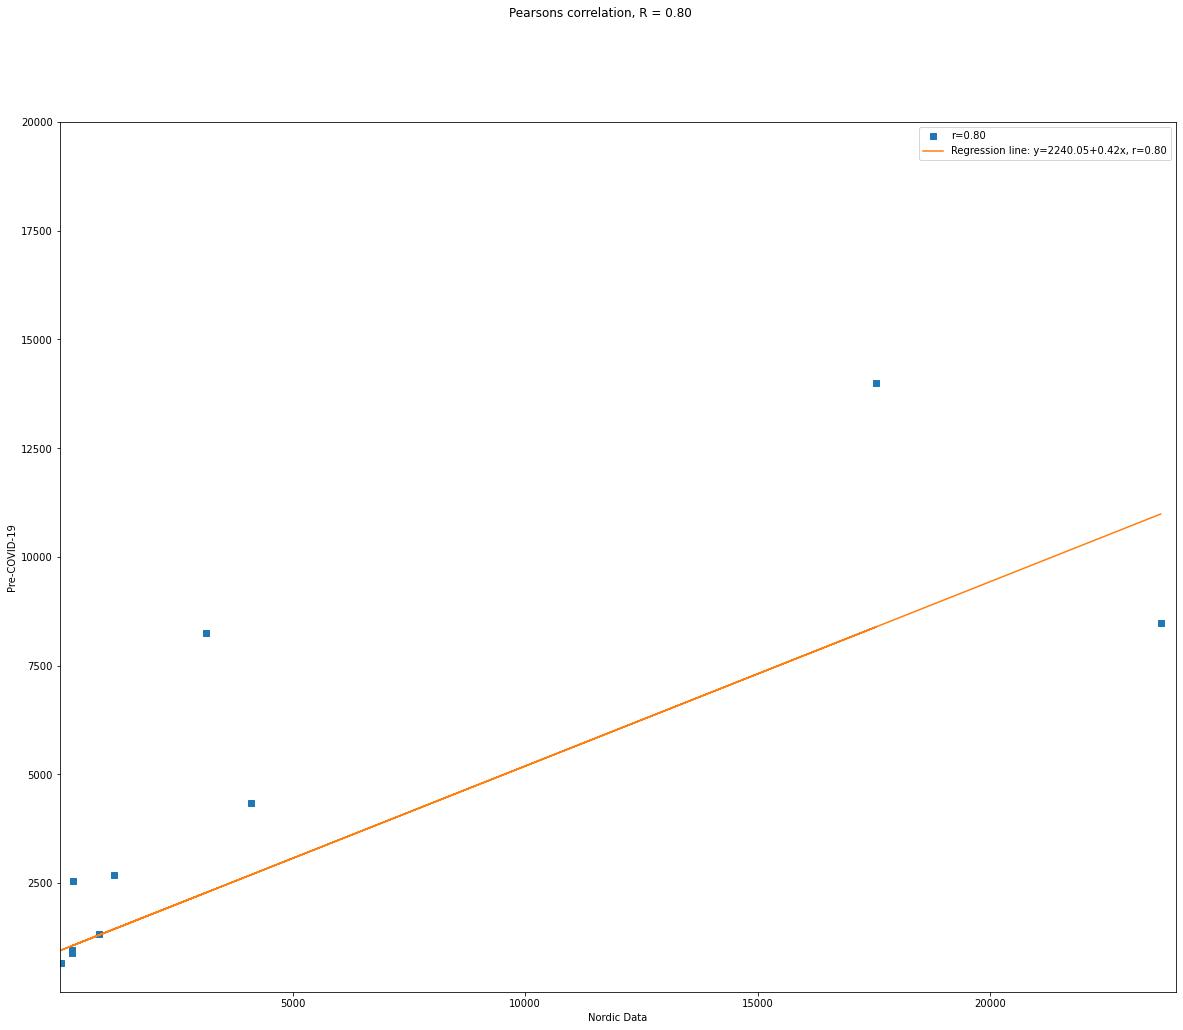

In [35]:
slope, intercept, r, p, stderr = scipy.stats.linregress(nordic_list_bidirectional, pre_list_bidirectional)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(nordic_list_bidirectional, pre_list_bidirectional, linewidth=0, marker='s', label=f'r={r:.2f}')
ax.plot(nordic_list_bidirectional,slope * (nordic_list_bidirectional +  intercept), label=line)
ax.set_xlabel('Nordic Data')
ax.set_ylabel('Pre-COVID-19')

ax.set_ylim(1,20000)
ax.set_xlim(1,24000)
fig.suptitle(f'Pearsons correlation, R = {r:.2f}')
print(f'Pearsons correlation, R = {r:.2f}')
ax.legend(facecolor='white')
plt.show()
#fig.savefig('../imgs/Correlation_Nordic_Pre.png', dpi=150)

Pearsons correlation, R = 0.83


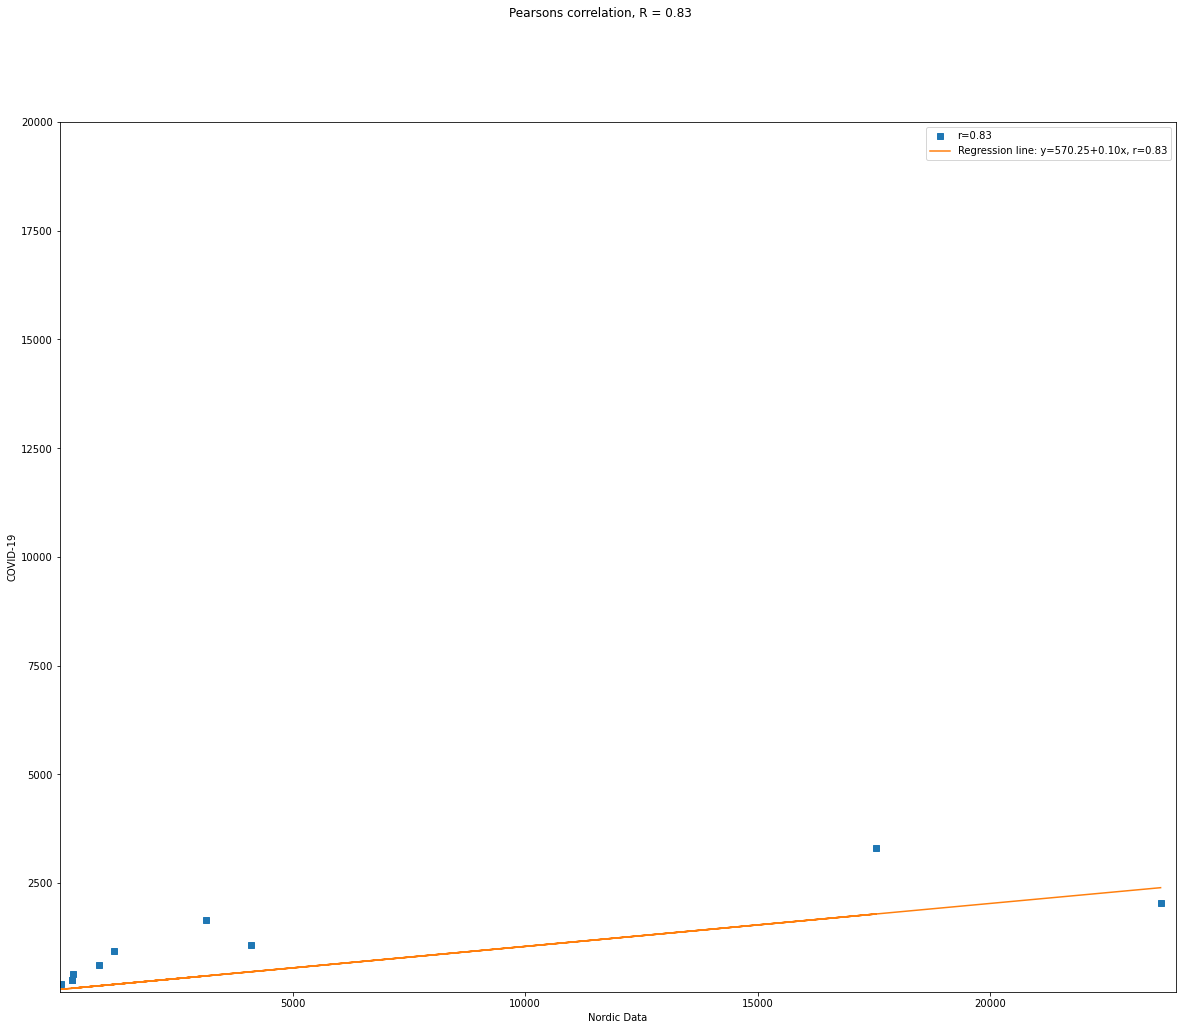

In [36]:
slope, intercept, r, p, stderr = scipy.stats.linregress(nordic_list_bidirectional, post_list_bidirectional)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(nordic_list_bidirectional, post_list_bidirectional, linewidth=0, marker='s', label=f'r={r:.2f}')
ax.plot(nordic_list_bidirectional,slope * (nordic_list_bidirectional +  intercept), label=line)
ax.set_xlabel('Nordic Data')
ax.set_ylabel('COVID-19')

ax.set_ylim(1,20000)
ax.set_xlim(1,24000)
fig.suptitle(f'Pearsons correlation, R = {r:.2f}')
print(f'Pearsons correlation, R = {r:.2f}')
ax.legend(facecolor='white')
plt.show()
#fig.savefig('../imgs/Correlation_Nordic_Post.png',dpi=150)

### Twitter only after geotag disabling

In [37]:
pre_list_bidirectional_subset = [len(pre_dk_fi[pre_dk_fi['yearmonth'] >= 201906]),
                          len(pre_dk_ic[pre_dk_ic['yearmonth'] >= 201906]),
                          len(pre_dk_no[pre_dk_no['yearmonth'] >= 201906]),
                          len(pre_dk_sw[pre_dk_sw['yearmonth'] >= 201906]),
                          len(pre_fi_ic[pre_fi_ic['yearmonth'] >= 201906]),
                          len(pre_fi_no[pre_fi_no['yearmonth'] >= 201906]),
                          len(pre_fi_sw[pre_fi_sw['yearmonth'] >= 201906]),
                          len(pre_ic_no[pre_ic_no['yearmonth'] >= 201906]),
                          len(pre_ic_sw[pre_ic_sw['yearmonth'] >= 201906]),
                          len(pre_no_sw[pre_no_sw['yearmonth'] >= 201906])
                         ]
post_list_bidirectional_subset = [len(post_dk_fi[post_dk_fi['yearmonth'] >= 202006]),
                           len(post_dk_ic[post_dk_ic['yearmonth'] >= 202006]),
                           len(post_dk_no[post_dk_no['yearmonth'] >= 202006]),
                           len(post_dk_sw[post_dk_sw['yearmonth'] >= 202006]),
                           len(post_fi_ic[post_fi_ic['yearmonth'] >= 202006]),
                           len(post_fi_no[post_fi_no['yearmonth'] >= 202006]),
                           len(post_fi_sw[post_fi_sw['yearmonth'] >= 202006]),
                           len(post_ic_no[post_ic_no['yearmonth'] >= 202006]),
                           len(post_ic_sw[post_ic_sw['yearmonth'] >= 202006]),
                           len(post_no_sw[post_no_sw['yearmonth'] >= 202006])
                          ]
nordic_list_bidirectional_subset = nordic_list_bidirectional[3:]

Pearsons correlation, R = 0.80


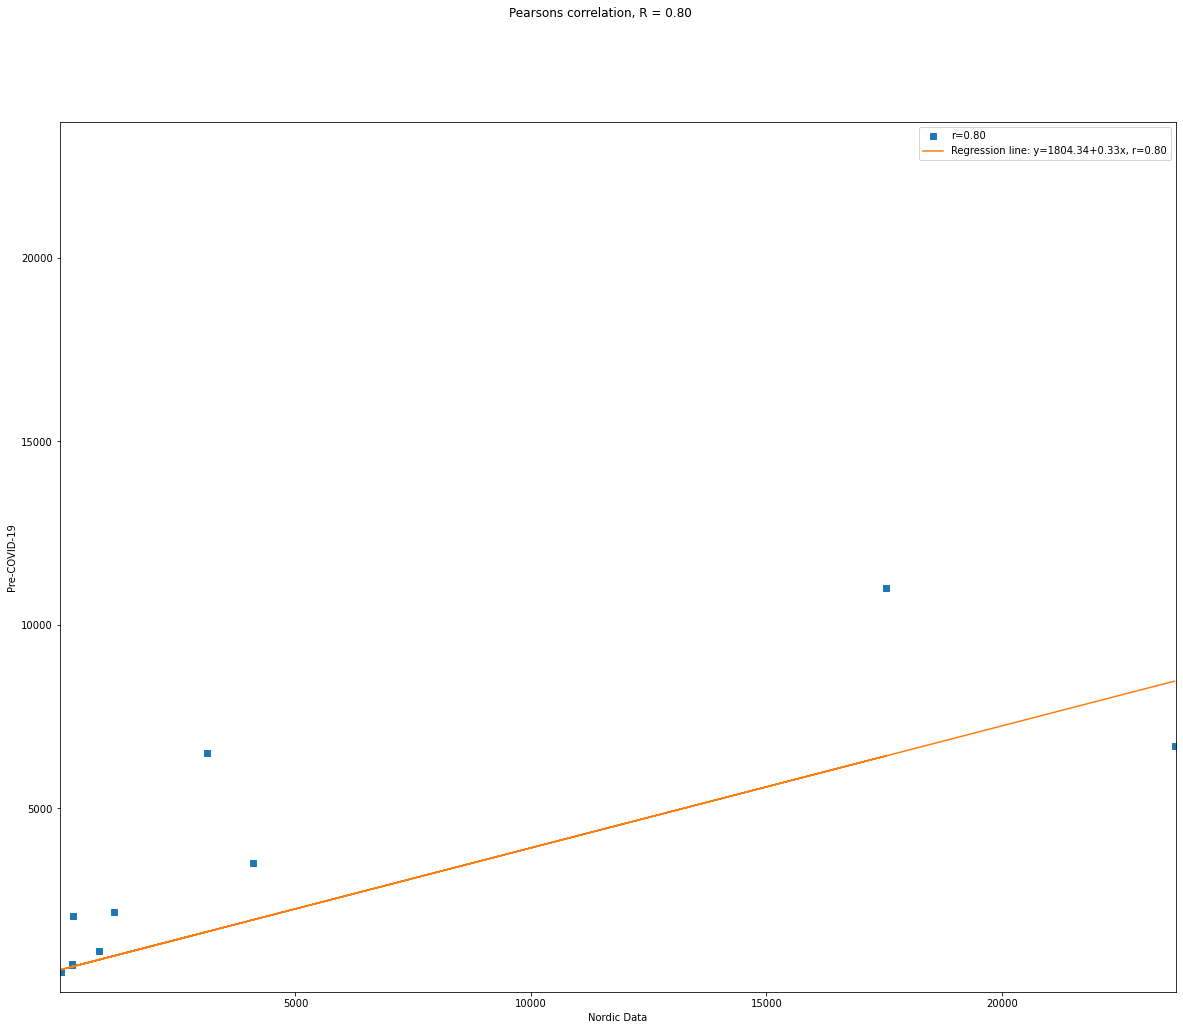

In [38]:
nordic_list_bidirectional = np.array(nordic_list_bidirectional)
slope, intercept, r, p, stderr = scipy.stats.linregress(nordic_list_bidirectional, pre_list_bidirectional_subset)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(nordic_list_bidirectional, pre_list_bidirectional_subset, linewidth=0, marker='s', label=f'r={r:.2f}')
ax.plot(nordic_list_bidirectional, slope * (nordic_list_bidirectional + intercept), label=line)
ax.set_xlabel('Nordic Data')
ax.set_ylabel('Pre-COVID-19')

ax.set_ylim(1,23700)
ax.set_xlim(1,23700)
fig.suptitle(f'Pearsons correlation, R = {r:.2f}')
print(f'Pearsons correlation, R = {r:.2f}')
ax.legend(facecolor='white')
plt.show()
#fig.savefig('../imgs/Correlation_Nordic_Pre_subset.png', dpi=150)

Pearsons correlation, R = 0.82


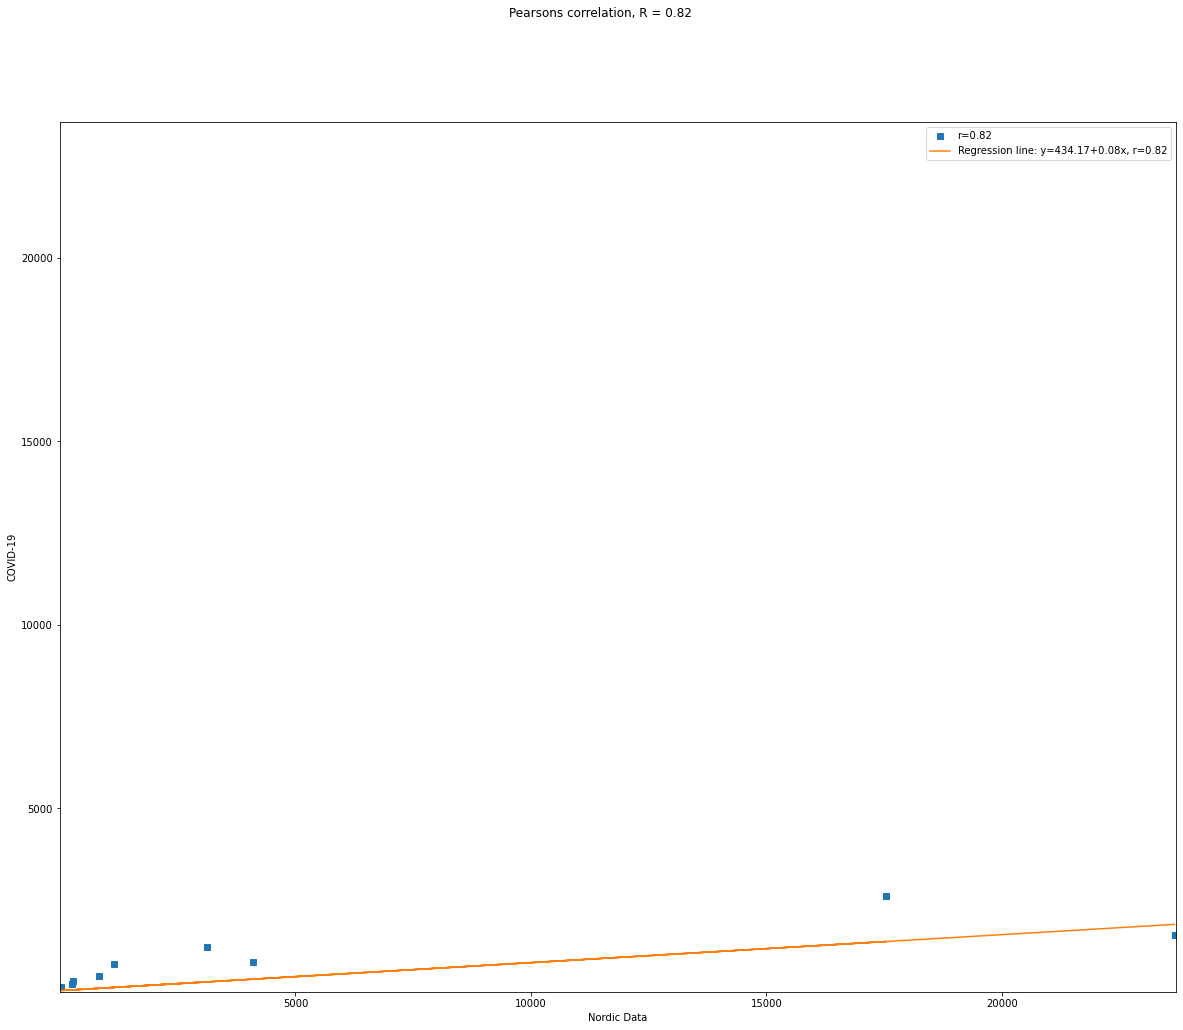

In [39]:
slope, intercept, r, p, stderr = scipy.stats.linregress(nordic_list_bidirectional, post_list_bidirectional_subset)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(nordic_list_bidirectional, post_list_bidirectional_subset, linewidth=0, marker='s', label=f'r={r:.2f}')
ax.plot(nordic_list_bidirectional, slope * (nordic_list_bidirectional + intercept), label=line)
ax.set_xlabel('Nordic Data')
ax.set_ylabel('COVID-19')

ax.set_ylim(1,23700)
ax.set_xlim(1,23700)
fig.suptitle(f'Pearsons correlation, R = {r:.2f}')
print(f'Pearsons correlation, R = {r:.2f}')
ax.legend(facecolor='white')
plt.show()
#fig.savefig('../imgs/Correlation_Nordic_Post_subset.png',dpi=150)

## Region Connectedness

In [40]:
pre_region_lines = pre_lines_gdf[~pre_lines_gdf['region_move'].str.contains('SE22-SE23|NO08-NO08|NO07-NO08|SE22-SE22|SE23-SE33|FI1B-FI1D|FI20-FI20|SE33-SE31|NO0A-NO07|FI1D-FI1B|NO08-NO07|NO06-NO07|NO0A-NO08')]
post_region_lines = post_lines_gdf[~post_lines_gdf['region_move'].str.contains('SE22-SE23|NO08-NO08|NO07-NO08|SE22-SE22|SE23-SE33|FI1B-FI1D|SE33-SE31|NO02-NO02|FI1D-FI1B|SE33-SE11')]
pre_values = pre_region_lines['region_move'].value_counts().to_dict()
post_values = post_region_lines['region_move'].value_counts().to_dict()


# Create strings for border crossings
regions = list(pre_lines_gdf['post_region'].unique())
new_dict = {}
post_dict = {}
region_pairs = []
for region in regions:
    for reg in range(len(regions)):
        appendstring = f"{region}-{regions[reg]}"
        if region[:2] == regions[reg][:2]:
            pass
        else:
            region_pairs.append(appendstring)
# pre_lines
for region_pair in region_pairs:
    regs = region_pair.split('-')
    first_pair = str(regs[0]+'-'+regs[1])
    second_pair = str(regs[1]+'-'+regs[0])
    if (first_pair in pre_values) and (second_pair in pre_values):
        pair_sum = pre_values[first_pair] + pre_values[second_pair]
    elif second_pair in pre_values:
        pair_sum = pre_values[second_pair]
    elif first_pair in pre_values:
        pair_sum = pre_values[first_pair]
    else:
        pair_sum = 0
    new_dict[first_pair] = pair_sum

for region_pair in region_pairs:
    regs = region_pair.split('-')
    first_pair = str(regs[0]+'-'+regs[1])
    second_pair = str(regs[1]+'-'+regs[0])
    if (first_pair in new_dict) and (second_pair in new_dict):
        new_dict.pop(second_pair)


# Sort dictionary
pre_sorted = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
# Sorted
pre_ordered = collections.OrderedDict(sorted(pre_sorted.items()))

In [41]:
# post_lines
for region_pair in region_pairs:
    regs = region_pair.split('-')
    first_pair = str(regs[0]+'-'+regs[1])
    second_pair = str(regs[1]+'-'+regs[0])
    if (first_pair in post_values) and (second_pair in post_values):
        pair_sum = post_values[first_pair] + post_values[second_pair]
    elif second_pair in post_values:
        pair_sum = post_values[second_pair]
    elif first_pair in post_values:
        pair_sum = post_values[first_pair]
    else:
        pair_sum = 0
    post_dict[first_pair] = pair_sum
for region_pair in region_pairs:
    regs = region_pair.split('-')
    first_pair = str(regs[0]+'-'+regs[1])
    second_pair = str(regs[1]+'-'+regs[0])
    if (first_pair in post_dict) and (second_pair in post_dict):
        post_dict.pop(second_pair)
post_sorted = {k: v for k, v in sorted(post_dict.items(), key=lambda item: item[1])}
#Sorted
post_ordered = collections.OrderedDict(sorted(post_sorted.items()))

In [42]:
i = 0
for k,v in post_ordered.items():
    
    pre_share = list(pre_ordered.values())[i]
    if pre_share == 0:
        print(f"{k}: No travels pre-covid, {v} post")
    else:
        result = round( ((v)/(pre_share) *100)-100 ,2)
        print(f"{k}: {result}")
    i += 1

DK01-FI19: -87.6
DK01-FI1B: -88.91
DK01-FI1C: -79.86
DK01-FI1D: -62.23
DK01-FI20: -84.62
DK01-IS00: -72.52
DK01-NO02: -70.27
DK01-NO06: -84.91
DK01-NO07: -68.79
DK01-NO08: -83.83
DK01-NO09: -78.29
DK01-NO0A: -78.65
DK01-SE12: -83.29
DK01-SE21: -80.82
DK01-SE22: -75.16
DK01-SE23: -83.66
DK01-SE31: -77.33
DK01-SE32: -65.12
DK01-SE33: -77.17
DK02-NO02: -62.5
DK03-FI1D: -81.48
DK03-FI20: -100.0
DK03-IS00: -68.42
DK03-NO02: -58.33
DK03-NO06: -68.0
DK03-NO09: -45.16
DK03-NO0A: -33.9
DK03-SE12: -77.14
DK03-SE21: -76.0
DK03-SE22: -69.55
DK03-SE23: -73.45
DK03-SE31: -75.0
DK03-SE33: -66.67
DK04-FI1D: -38.89
DK04-NO02: -36.36
DK04-NO06: -76.19
DK04-NO09: -74.63
DK04-SE12: -69.44
DK04-SE21: -77.14
DK05-FI1D: -75.0
DK05-NO02: -83.33
DK05-NO06: -100.0
DK05-NO09: -66.0
DK05-SE12: -75.0
DK05-SE21: -31.58
DK05-SE33: -90.0
FI19-DK02: -36.36
FI19-DK03: -79.41
FI19-DK04: -76.19
FI19-DK05: -82.35
FI19-IS00: -85.29
FI19-NO02: -100.0
FI19-NO06: -93.75
FI19-NO09: -66.67
FI19-NO0A: -65.71
FI19-SE12: -60.47
FI

### Sankey Chart Finland

In [43]:
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [44]:
pre_values_fi = pre_region_lines[pre_region_lines['region_move'].str.contains('FI')]
pre_values_fi = pre_values_fi[~pre_values_fi['region_move'].str.match('FI1D-FI1D|FI1D-FI1C|FI1D-FI19|FI20-FI19|FI19-FI19|FI19-FI1D|FI19-FI1B|FI19-FI1C|FI1C-FI1D|FI20-FI1D|FI1D-FI20|FI19-FI20')]
post_values_fi = post_region_lines[post_region_lines['region_move'].str.contains('FI')]

In [45]:
to_finland = pre_values_fi[pre_values_fi['region_move'].str.contains('-FI')]
from_finland = pre_values_fi[pre_values_fi['region_move'].str.match('FI')]

post_to_finland = post_values_fi[post_values_fi['region_move'].str.contains('-FI')]
post_from_finland = post_values_fi[post_values_fi['region_move'].str.match('FI')]
print(to_finland['region_move'].value_counts())
print(from_finland['region_move'].value_counts())
print(post_to_finland['region_move'].value_counts())
print(post_from_finland['region_move'].value_counts())

SE11-FI1B    1701
DK01-FI1B     759
NO08-FI1B     431
SE11-FI1C     339
SE33-FI1D     230
             ... 
IS00-FI20       2
DK02-FI20       1
NO0A-FI20       1
DK04-FI20       1
DK05-FI20       1
Name: region_move, Length: 95, dtype: int64
FI1B-SE11    1727
FI1B-DK01     738
FI1B-NO08     430
FI1C-SE11     290
FI1D-NO07     235
             ... 
FI20-NO07       2
FI20-DK03       1
FI20-NO0A       1
FI20-IS00       1
FI20-DK04       1
Name: region_move, Length: 95, dtype: int64
SE11-FI1B    197
NO07-FI1D    149
SE33-FI1D    142
DK01-FI1B     91
NO07-FI1B     56
            ... 
DK02-FI20      1
FI1D-FI19      1
DK05-FI1D      1
IS00-FI20      1
SE33-FI20      1
Name: region_move, Length: 88, dtype: int64
FI1B-SE11    193
FI1D-SE33    145
FI1D-NO07    139
FI1B-DK01     75
FI1B-NO08     60
            ... 
FI1D-FI19      1
FI20-SE23      1
FI1B-DK02      1
FI20-IS00      1
FI1C-IS00      1
Name: region_move, Length: 91, dtype: int64


In [46]:
color_map = ['rgba(255, 237, 159, 0.5)', 'rgba(221, 104, 230, 0.5)', 'rgba(255, 67, 68,0.5)','rgba(77, 235, 109, 0.5)']
color_countries = ['rgb(255, 237, 159)', 'rgb(221, 104, 230)', 'rgb(255, 67, 68)','rgb(77, 235, 109)','rgb(75, 97, 255)']
colors = {'sweden': ['rgb(255, 237, 159)','rgba(255, 237, 159, 0.5)'], 'norway': ['rgb(221, 104, 230)','rgba(221, 104, 230, 0.5)'],'denmark':['rgb(255, 67, 68)','rgba(255, 67, 68,0.5)'], 'iceland': ['rgb(77, 235, 109)', 'rgba(77, 235, 109, 0.5)'], 'finland':['rgb(75, 97, 255)','rgba(75, 97, 255, 0.5)']}
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 25,
      line = dict(color = "black", width = 1),
      label = ["Stockholm (SE)", "Hovedstaden (DK)", "Oslo og Viken (NO)","Nord-Norge (NO)","Övre Norrland (SE)","Ísland (IS)","Västsverige (SE)",   "Helsinki-Uusimaa (FI)", "Etelä-Suomi (FI)","Pohjois- ja Itä-Suomi (FI)","Länsi-Suomi (FI)","Åland (FI)",        "Stockholm (SE)", "Nord-Norge (NO)", "Övre Norrland (SE)","Hovedstaden (DK)","Oslo og Viken (NO)", "Ísland (IS)"],
      color = [colors['sweden'][0], colors['denmark'][0], colors['norway'][0], colors['norway'][0],colors['sweden'][0],colors['iceland'][0],colors['sweden'][0], colors['finland'][0], colors['finland'][0],colors['finland'][0],colors['finland'][0],colors['finland'][0] , colors['sweden'][0],colors['norway'][0],colors['sweden'][0],colors['denmark'][0],colors['norway'][0],colors['iceland'][0]]
    ),
    link = dict(
        source = [0,1,2,0,3,4,0,5,0,6, 7,9,9,7,7,9,7,9,8,10],
        target = [7,7,7,8,9,9,10,7,11,7, 12,13,14,15,16,12,13,17,12,12],
        value = [3428,1497,861,629, 458,455,421,407,370,348, 390,288,287,166,113,107,102,97,93,76],
        color = [colors['sweden'][1],colors['denmark'][1],colors['norway'][1],colors['sweden'][1],colors['norway'][1],colors['sweden'][1],colors['sweden'][1],colors['iceland'][1],colors['sweden'][1],colors['sweden'][1],  colors['sweden'][1],colors['norway'][1],colors['sweden'][1],colors['denmark'][1],colors['norway'][1],colors['sweden'][1],colors['norway'][1],colors['iceland'][1],colors['sweden'][1],colors['sweden'][1]]
    ))])
fig.update_layout(
    font = dict(
        size=20,
        color='black',
    )
)
plot(fig)

'temp-plot.html'